In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
2,deg=3,polynomial_regression_1dim,Transformer,,-1,-1,1,12,8,polynomial_regression_1_dim
3,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
4,pretrained,sine2exp,Transformer,"A_range=[0.1, 5.0]_B_range=[0.1, 5.0]_C_range=...",-1,-1,1,12,8,sine2exp
5,pretrained,sine_task,Transformer,"A_range=[0.1, 5.0]_B_range=[0.1, 5.0]_C_range=...",-1,-1,5,12,8,sine_task
6,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
#task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
#task = 'sine2cosine'
#task = 'sine2periodic'
task = "sine2exp"
#run_id = "pretrained"  # if you train more models, replace with the run_id from the table above
run_id = 'pretrained'
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path, skip_baselines=False, cache=False)

# Plot pre-computed metrics

In [4]:
import numpy as np

def large_plot(metrics, models=None, trivial=1.0, clip_quantile=1.0, max_ylim=None):
    fig, ax = plt.subplots(1, 1)

    if models is not None:
        metrics = {k: metrics[k] for k in models if k in metrics}

    color = 0
    # ax.axhline(trivial, ls="--", color="gray")

    all_high_vals = []

    for name, vs in metrics.items():
        mean = vs["mean"]
        low = vs["bootstrap_low"]
        high = vs["bootstrap_high"]

        ax.plot(mean, "-", label=name, color=palette[color % 10], lw=2)
        # ax.fill_between(range(len(low)), low, high, alpha=0.3)

        all_high_vals.extend(high)
        color += 1

    ax.set_xlabel("in-context examples")
    ax.set_ylabel("squared error")

    # 设定 y 轴最大值
    if len(all_high_vals) > 0:
        y_upper = np.quantile(all_high_vals, clip_quantile)  # 默认取 95% 分位数
        if max_ylim is not None:
            y_upper = min(y_upper, max_ylim)
        ax.set_ylim(-0.1, y_upper * 1.1)
    else:
        ax.set_ylim(-0.1, 1.0)

    legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig.set_size_inches(5, 4)
    for line in legend.get_lines():
        line.set_linewidth(3)

    return fig, ax


In [5]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

# metrics = collect_results(run_dir, df, valid_row=valid_row)
metrics = get_run_metrics(run_path, cache=False, skip_baselines=False)

100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


dict_keys(['gpt2_embd=256_layer=12_head=8', 'OLS_driver=None', 'NN_n=3_uniform', 'averaging'])


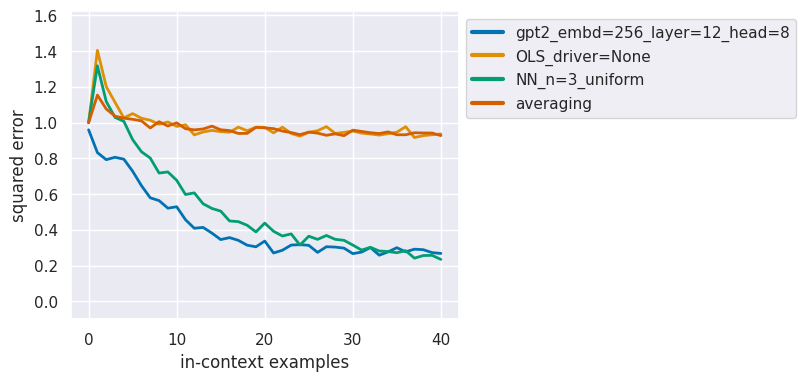

gpt2_embd=256_layer=12_head=8: {'mean': [0.9600744247436523, 0.8325344920158386, 0.7929841876029968, 0.8063638806343079, 0.7956980466842651, 0.7283156514167786, 0.6475334167480469, 0.5794776082038879, 0.5638770461082458, 0.5215404629707336, 0.5294767618179321, 0.4569626748561859, 0.4092109799385071, 0.4138909876346588, 0.3821529746055603, 0.3457748293876648, 0.3568403124809265, 0.3414841592311859, 0.31440460681915283, 0.30533021688461304, 0.33752697706222534, 0.2708362638950348, 0.2860589623451233, 0.3150973320007324, 0.31745100021362305, 0.31364336609840393, 0.2740984559059143, 0.30580583214759827, 0.30386286973953247, 0.29796361923217773, 0.2670891284942627, 0.2758943736553192, 0.30135026574134827, 0.2585059106349945, 0.27700430154800415, 0.3003461956977844, 0.27711543440818787, 0.29211679100990295, 0.28923770785331726, 0.2728773355484009, 0.26838165521621704], 'std': [1.054458498954773, 0.9673529863357544, 0.9998033046722412, 1.290578842163086, 1.3379217386245728, 1.3143763542175293

In [6]:
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

# models = relevant_model_names[task]
models = list(metrics["standard"].keys())

print(metrics["standard"].keys())

# basic_plot(metrics["standard"], models=models)
large_plot(metrics["standard"], models=models)
plt.show()

for model in models:
    if model in metrics["standard"]:
        loss_tensor = metrics["standard"][model]
        print(f"{model}: {loss_tensor}")
    else:
        print(f"{model}: not found in metrics")


In [7]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [8]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [9]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [10]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs,mode="period")

In [11]:
print(xs[0][0])

tensor([0.3104])


In [12]:
print(ys[0][0])

tensor(-1.)


In [13]:
with torch.no_grad():
    pred = model(xs, ys)

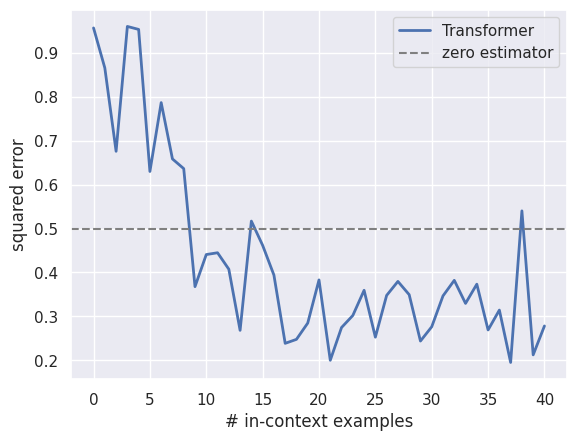

In [14]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "sine_regression": 1.0,
    "sine2cosine":1,
    "sine2periodic":1,
    "poly_function_regression":125,
    "hard_sine2sawtooth":0.5,
    "hard_sine2square":0.5,
    "poly2tanhregression":1.5,
    "poly_to_softsign_regression":25,
    "sine2exp":0.5,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [15]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2, mode="period")
with torch.no_grad():
    pred2 = model(xs2, ys2)

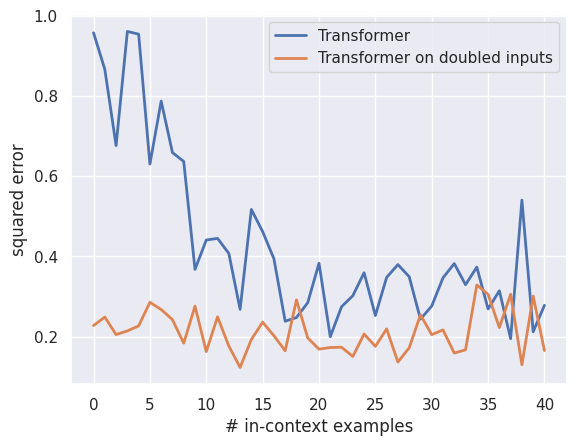

In [16]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [ ]:
with torch.no_grad():
    # 获取模型中参数所在的设备
    device = next(model.parameters()).device

    # 构造输入为全 0 的向量
    zero_xs = torch.zeros_like(xs).to(device)
    ys_on_device = torch.ones_like(ys).to(device)

    pred_zero = model(zero_xs, ys_on_device)

    print("The result when input is zeros:")
    print(pred_zero.cpu())
    print(ys_on_device.cpu())
    print(zero_xs)


模型在输入为 0 时的预测结果：
tensor([[1.6643, 1.0077, 1.0177,  ..., 1.0158, 1.0715, 1.0631],
        [1.6643, 1.0077, 1.0177,  ..., 1.0158, 1.0715, 1.0631],
        [1.6643, 1.0077, 1.0177,  ..., 1.0158, 1.0715, 1.0631],
        ...,
        [1.6643, 1.0077, 1.0177,  ..., 1.0158, 1.0715, 1.0631],
        [1.6643, 1.0077, 1.0177,  ..., 1.0158, 1.0715, 1.0631],
        [1.6643, 1.0077, 1.0177,  ..., 1.0158, 1.0715, 1.0631]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,
